Importation des library

In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os

Chargement des données

In [ ]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
time = '15m'
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [3]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-06 17:00:00+01:00,3052.40,3041.69,3066.62,3040.84,10825.8147
2025-12-06 18:00:00+01:00,3055.36,3052.40,3060.00,3047.00,6639.3158
2025-12-06 19:00:00+01:00,3042.41,3055.36,3056.05,3038.37,6569.2369
2025-12-06 20:00:00+01:00,3030.44,3042.41,3048.07,3025.00,9214.4600
2025-12-06 21:00:00+01:00,3039.96,3030.45,3041.31,3030.07,2878.8245


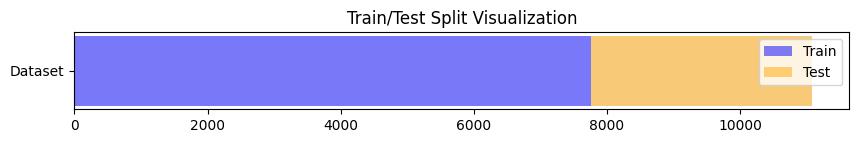

In [4]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [ ]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

**La stratégie**

Type : Mean Reversion
Indicateur : BBLOG
Entrée : Cloture au dessous de la bande basse des bandes de bollinger
Sortie :
Cloture au dessus de la bande haute des bandes de bollinger
Ou
Stop Loss : 5%

In [6]:
def generate_bblog_signals(df, column='Close', window=50, std_dev=1.6):
    # Calcul de la moyenne mobile et écart type
    middle_band = df[column].rolling(window=window).mean()
    roll_std = df[column].rolling(window=window).std()
    
    # Calcul des bandes sup/inf
    df['upper_band'] = middle_band + (std_dev * roll_std)
    df['lower_band'] = middle_band - (std_dev * roll_std)
    
    # Génération des signaux
    df['bb_signal'] = np.where(df[column] < df['lower_band'], 1, 0)
    df['bb_signal'] = np.where(df[column] > df['upper_band'], -1, df['bb_signal'])
     
    return df.dropna()

In [55]:
# Génération des signaux
df = generate_bblog_signals(df, column='Close', window=20, std_dev=1.8)
df.tail()

,Close,Open,High,Low,Volume,upper_band,lower_band,bb_signal
Open time,,,,,,,,
2025-07-21 04:00:00+02:00,3743.31,3723.67,3749.00,3722.17,23775.0767,3799.197398,3687.702602,0
2025-07-21 05:00:00+02:00,3757.37,3743.30,3766.28,3743.30,23554.6014,3793.886087,3701.901913,0
2025-07-21 06:00:00+02:00,3761.76,3757.38,3779.64,3753.11,27164.4947,3794.004517,3706.808483,0
2025-07-21 07:00:00+02:00,3782.81,3761.76,3784.32,3747.38,23107.1875,3795.560936,3712.821064,0
2025-07-21 08:00:00+02:00,3787.37,3782.82,3812.49,3776.50,36394.0721,3794.991135,3722.164865,0


In [56]:
def plot_strategy(df, start_date='', end_date=''):
    # Sélection d'une plage de dates spécifique
    data_to_plot = df[start_date:end_date]

    # Création d'une figure avec un seul graphique
    fig, ax = plt.subplots(figsize=(15, 7))

    # Tracer le prix et les bandes
    ax.plot(data_to_plot.index, data_to_plot['Close'], label='Prix', color='blue', alpha=0.7)
    ax.plot(data_to_plot.index, data_to_plot['upper_band'], label='Bande Supérieure', color='gray', linestyle='--', alpha=0.5)
    ax.plot(data_to_plot.index, data_to_plot['lower_band'], label='Bande Inférieure', color='gray', linestyle='--', alpha=0.5)

    # Tracer les signaux d'entrée (triangles verts vers le haut)
    entries = data_to_plot[data_to_plot['bb_signal'] == 1].index
    ax.scatter(entries, data_to_plot.loc[entries, 'Close'],
              color='green', marker='^', s=100, label='Signal d\'Entrée')

    # Tracer les signaux de sortie (triangles rouges vers le bas)
    exits = data_to_plot[data_to_plot['bb_signal'] == -1].index
    ax.scatter(exits, data_to_plot.loc[exits, 'Close'],
              color='red', marker='v', s=100, label='Signal de Sortie')

    # Personnaliser le graphique
    ax.set_title('Stratégie de Trading - Prix et Signaux')
    ax.set_ylabel('Prix')
    ax.set_xlabel('Date')

    # Ajouter la légende
    ax.legend(loc='upper left')

    # Ajouter une grille
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

**VUE GRAPHIQUES DES SIGNAUX**

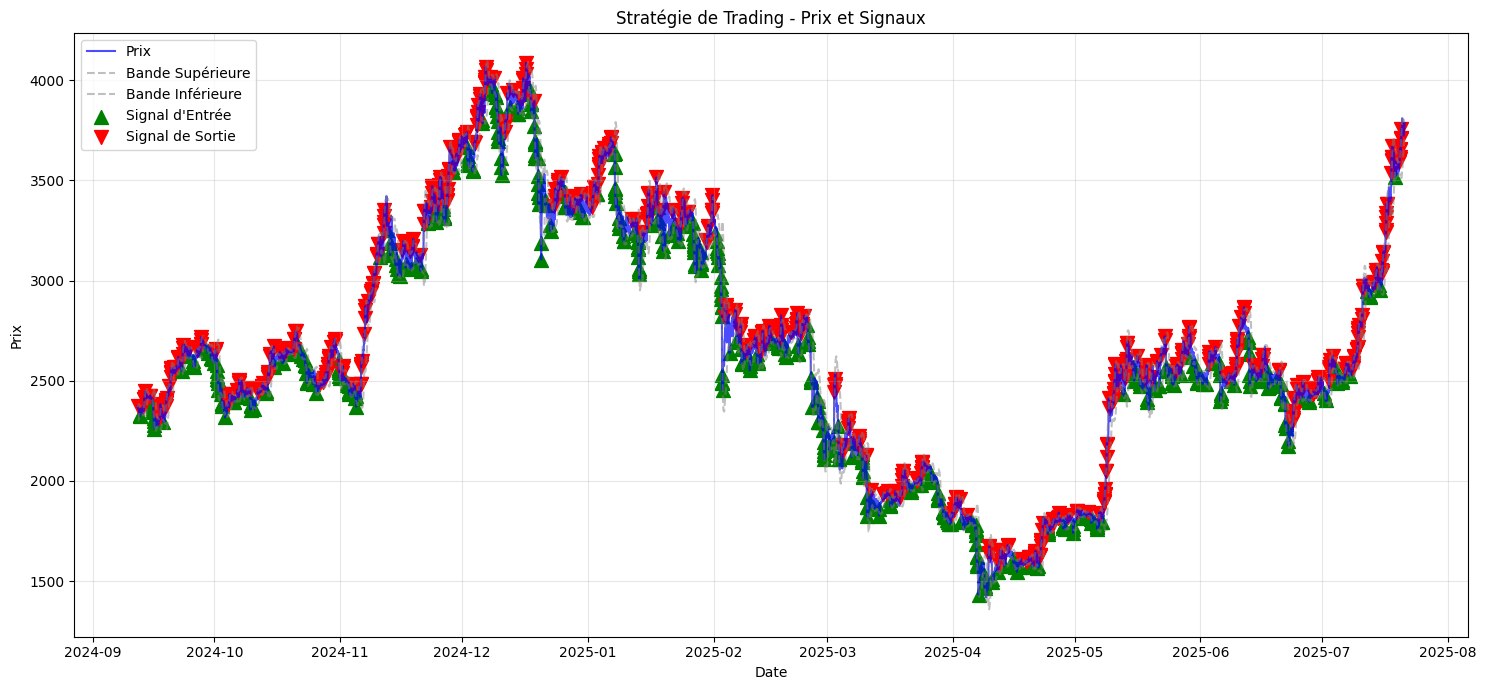

In [57]:
# Visualisation des signaux de toute la période des données récupérées
plot_strategy(df, start_date=df.index[0], end_date=df.index[-1])

**Backtest**

In [58]:
# Lancement du backtest avec VBT
# Fonction From Signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['bb_signal']==1,
    exits=df['bb_signal']==-1,
    sl_stop=0.05,
    #tp_stop=0.05,
    init_cash=50,
    # valeur fixe par trade (60% du capital)
    size_type='percent',
    size=0.6,
    # effet de levier
    
    fees=0.001, #Taker Binance = 0.1%
    slippage=0.001, #aprox
    freq=time
)

stats = portfolio.stats()
# Affichage des statistiques
print(portfolio.stats())
# ajout des statistique dans un csv (les ajouter a la suite et ne pas écraser les données existantes)
stats = portfolio.stats().to_frame().T
stats.to_csv('backtest_stats.csv', mode='a',header=not os.path.exists('backtest_stats.csv'),index=False,)


# Tracer la valeur du portefeuille
#portfolio.plot(width=1000, height=1000).show()

# Afficher les Trades
#fig = portfolio.trades.plot()
#fig.update_layout(width=1200, height=600)
#fig.show()

Start                         2024-09-12 03:00:00+02:00
End                           2025-07-21 08:00:00+02:00
Period                                312 days 06:00:00
Start Value                                        50.0
End Value                                     53.132711
Total Return [%]                               6.265421
Benchmark Return [%]                          59.603285
Max Gross Exposure [%]                        62.413734
Total Fees Paid                                8.238824
Max Drawdown [%]                              27.962358
Max Drawdown Duration                 224 days 01:00:00
Total Trades                                        137
Total Closed Trades                                 137
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  64.963504
Best Trade [%]                                13.298997
Worst Trade [%]                              -11